<br>

<b>Imports and Constants</b>

In [1]:
# !pip install -q --upgrade tokenizer-viz

# Regular imports (native python and pypi packages)
import os
import sys
import ast
import random
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import sentencepiece as spm
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from tokenizer_viz import TokenVisualization
from tqdm.notebook import tqdm; tqdm.pandas()
from typing import Callable, List, Optional, Union

# Add project root into path so imports work
PROJECT_DIR = os.path.dirname(os.getcwd())
sys.path.insert(0, PROJECT_DIR) 

# Our project imports
from spearecode.utils.preprocessing_utils import (
    load_from_txt_file, preprocess_shakespeare, save_to_txt_file, print_check_speare, get_spm_assets
)
from spearecode.utils.general_utils import (
    tf_xla_jit, tf_set_memory_growth, seed_it_all, flatten_l_o_l, print_ln
)
from spearecode.utils.filtering_utils import (
    save_ds_version, drop_str_from_col_names, pad_truncate_centered,
    get_metadata_df, check_chunks, tokenize, get_n_tokens,
    get_n_lines, get_n_chars
)
from spearecode.utils.tfrecord_utils import write_tfrecords, load_tfrecord_dataset

TRAIN_STYLE = "rcts_bpe_v4"
CHUNK_STYLE, TOK_STYLE, DS_VERSION = TRAIN_STYLE.split("_")

### DEFINE PATHS --- [PROJECT_DIR="/home/paperspace/home/spearecode"] --- ###
NBS_PATH = os.path.join(PROJECT_DIR, "nbs")
DATA_PATH = os.path.join(PROJECT_DIR, "data")
SS_TEXT_PATH = os.path.join(DATA_PATH, "t8.shakespeare.txt")
PREPROCESSED_FULL_TEXT_PATH = SS_TEXT_PATH.replace(".txt", "_preprocessed.txt")

DATASETS_PATH = os.path.join(DATA_PATH, "datasets") 
META_DIR = os.path.join(DATASETS_PATH, "meta") 
TFRECORD_DIR = os.path.join(DATASETS_PATH, "tfrecords", TRAIN_STYLE)
MODELS_DIR = os.path.join(PROJECT_DIR, "models")

# Specific Paths
SPM_MODEL_PATH = os.path.join(MODELS_DIR, f"spearecode_{TOK_STYLE}")
DATA_CSV_PATH  = os.path.join(DATASETS_PATH, f"{DS_VERSION}_{CHUNK_STYLE}_{TOK_STYLE}.csv")
META_CSV_PATH  = os.path.join(META_DIR, f"{DS_VERSION}_{CHUNK_STYLE}_{TOK_STYLE}.csv")

sp, encoder, decoder = get_spm_assets(SPM_MODEL_PATH)
viz_tool = TokenVisualization(encoder, decoder, background_color="#FBFBFB", transparency=0.4)

<br>

<b>Instantiate expected tools for the reset of the notebook</b>

In [2]:
MASK_TOKEN_STR = "[MASK]"
MASK_TOKEN_INT = encoder(MASK_TOKEN_STR)[0]

train_df = pd.read_csv(DATA_CSV_PATH)
train_df.token_content = train_df.token_content.apply(ast.literal_eval)
meta_df  = pd.read_csv(META_CSV_PATH)

display(train_df)
display(meta_df)

_ = viz_tool.visualize(train_df.token_content.sample(1).values[0], display_inline=True)

,content,token_content,n_tokens,n_chars,n_lines
0,1\n From fairest creatures we desire increase...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",173,643,15
1,2\n When forty winters shall besiege thy brow...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",180,662,15
2,3\n Look in thy glass and tell the face thou ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",170,643,15
3,"4\n Unthrifty loveliness why dost thou spend,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",166,619,15
4,5\n Those hours that with gentle work did fra...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",164,652,15
...,...,...,...,...,...
26717,"'This said, his wat'ry eyes he did dismount, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",264,961,23
26718,"'O father, what a hell of witchcraft lies\n I...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",262,941,23
26719,"'For lo, his passion, but an art of craft,\n ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",268,965,23
26720,"'In him a plenitude of subtle matter,\n Appli...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",274,964,23


,n_tokens,n_chars,n_lines
0,173,643,15
1,180,662,15
2,170,643,15
3,166,619,15
4,164,652,15
...,...,...,...
26717,264,961,23
26718,262,941,23
26719,268,965,23
26720,274,964,23


<br>

<b>Create Datasets</b>

In [5]:
# Get all tfrecords and shuffle
ALL_TFRECORDS = sorted(glob(os.path.join(TFRECORD_DIR, "*.tfrec")))
N_TOTAL_RECS = len(ALL_TFRECORDS)


EX_PER_TFREC = 100
VAL_PCT = 0.08
N_VAL_RECS = int(VAL_PCT*N_TOTAL_RECS)

VAL_TFRECORDS = ALL_TFRECORDS[:N_VAL_RECS]
TRAIN_TFRECORDS = ALL_TFRECORDS[N_VAL_RECS:]

random.shuffle(TRAIN_TFRECORDS)
random.shuffle(VAL_TFRECORDS)

<br>

<b>Training Configuration</b>

In [19]:
train_config = dict(
    batch_size=128,
    shuffle_buffer=256,
    encoder_context_len=64,
    decoder_context_len=96,
    mask_token_id=sp.encode("[MASK]")[0],
    vocab_size=sp.vocab_size(),
    n_epochs=250
)

<br>

<b>TF.Data Pipeline</b>

In [20]:
from typing import Tuple

# --- Pipeline Steps ---
# 
# 1. Shuffle examples (shuffle_buffer)
# 2. Batch examples (batch_size, drop_remainder, AUTOTUNE)
# 3. Split sequence into encoder/decoder inputs [`split_on_pivot`]
# 4. Split encoder inputs into:
#       --> 'inputs' (masked sequence)
#       --> 'labels' (unaltered sequence)
#       --> 'weights' (sample weights; 1.0 for masked tokens and 0.0 for non-mask tokens)
# 5. Split decoder inputs into:
#       --> 'inputs' (unaltered sequence)
#       --> 'labels' (sequence shifted by 1)

def split_on_pivot(tokens: tf.Tensor, 
                   encoder_context_len: int = 128, 
                   decoder_context_len: int = 64, 
                   center_stray_lim: int = 8, 
                   seq_len: int = 384) -> Tuple[tf.Tensor, tf.Tensor]:
    """ Sample encoder and decoder input sequences from a batch of tokens with random pivot indices.
    
    Args:
        tokens: A batch of token sequences with shape (batch_size, seq_len).
        encoder_context_len: The number of tokens to be sampled for the encoder input sequences.
        decoder_context_len: The number of tokens to be sampled for the decoder input sequences.
        seq_len: The total length of each token sequence in the batch.

    Returns:
        encoder_inputs: A tensor with shape (batch_size, encoder_context_len) containing the
                        sampled encoder input sequences.
        decoder_inputs: A tensor with shape (batch_size, decoder_context_len) containing the
                        sampled decoder input sequences.

    Raises:
        AssertionError: If the sum of encoder_context_len and decoder_context_len is greater than seq_len.
    """
    
    # Add one to our decoder context length as we need it for AR head
    decoder_context_len+=1
    assert encoder_context_len + decoder_context_len <= seq_len
    
    batch_size = tf.shape(tokens)[0]
    c_point = seq_len // 2
    
    # Sample random pivot indices for each sequence in the batch
    pivot_indices = tf.random.uniform(
        shape=(batch_size, 1), 
        minval=c_point - min((c_point - encoder_context_len), center_stray_lim),
        maxval=c_point + min((c_point - decoder_context_len), center_stray_lim),
        dtype=tf.int32
    )

    # Extract indices for examples before and after the pivot
    indices_before = tf.range(-encoder_context_len, 0, dtype=tf.int32)
    indices_after = tf.range(0, decoder_context_len, dtype=tf.int32)

    # Compute the final indices for sampling from the data
    indices_before = tf.expand_dims(pivot_indices, 1) + indices_before
    indices_after = tf.expand_dims(pivot_indices, 1) + indices_after

    # Gather the corresponding examples from the data
    encoder_inputs = tf.squeeze(tf.gather(tokens, indices_before, axis=1, batch_dims=1))
    decoder_inputs = tf.squeeze(tf.gather(tokens, indices_after, axis=1, batch_dims=1))

    # Reshape the encoder_inputs and decoder_inputs tensors
    encoder_inputs = tf.reshape(encoder_inputs, (batch_size, encoder_context_len))
    decoder_inputs = tf.reshape(decoder_inputs, (batch_size, decoder_context_len))

    return tf.cast(encoder_inputs, tf.int32), tf.cast(decoder_inputs, tf.int32)


def mask_sequence(sequence, vocab_size, mask_token_id, 
                  pct_to_mask=0.15, pct_to_random=0.1, pct_to_keep=0.1):
        """ Mask a sequence of tokens. """

        # Calculate the probability of masking each token
        masking_prob = tf.random.uniform(shape=tf.shape(sequence), minval=0, maxval=1)
        masking_prob = tf.where(sequence==0, 1.0, masking_prob)
        # Calculate the mask based on the masking probability
        mask = tf.cast(masking_prob < pct_to_mask, tf.int32)
        
        # Calculate the probability of replacing with a random token
        random_prob_mask = tf.cast(masking_prob < (pct_to_mask * pct_to_random), tf.int32)

        # Calculate the probability of keeping the original token
        keep_prob_mask = tf.cast(masking_prob < (pct_to_mask * pct_to_keep), tf.int32)

        # Replace the masked tokens with the mask_token_id
        masked_sequence = tf.where(mask == 1, mask_token_id * tf.ones_like(sequence, dtype=tf.int32), sequence)

        # Replace random_prob_mask tokens with random tokens
        random_tokens = tf.random.uniform(
            shape=tf.shape(sequence), minval=1, maxval=vocab_size, dtype=tf.int32
        )

        # Replace the masked tokens with the mask_token_id
        masked_sequence = tf.where(random_prob_mask == 1, random_tokens, masked_sequence)

        # Keep the original tokens for keep_prob_mask
        masked_sequence = tf.where(keep_prob_mask == 1, sequence, masked_sequence)

        # Generate sample weights for masked tokens
        sample_weights = tf.cast(mask, tf.float32)

        return masked_sequence, sequence, sample_weights


def shift_and_split_decoder_inputs(x: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """ TBD """
    window_size = tf.shape(x)[1]-1
    
    # Get the indices for the first and second vectors
    input_indices = tf.range(0, window_size, dtype=tf.int32)
    output_indices = tf.range(1, window_size+1, dtype=tf.int32)

    # Gather the corresponding columns for the first and second vectors
    decoder_inputs = tf.gather(x, input_indices, axis=-1)
    decoder_outputs = tf.gather(x, output_indices, axis=-1)

    return decoder_inputs, decoder_outputs
    
def transform_sequence(sequence, vocab_size, mask_token_id, encoder_context_len, decoder_context_len, **kwargs):
    
    # Pivot split
    encoder_inputs, decoder_inputs = split_on_pivot(sequence, encoder_context_len, decoder_context_len)
    # Encoder transform
    encoder_inputs, encoder_labels, encoder_sample_wts = mask_sequence(
        encoder_inputs, vocab_size, tf.constant(MASK_TOKEN_INT, dtype=tf.int32)
    )

    # Decoder transform
    decoder_inputs, decoder_labels = shift_and_split_decoder_inputs(decoder_inputs)
    decoder_sample_wts = tf.ones_like(decoder_labels, dtype=tf.float32)
    
    _inputs = (encoder_inputs, decoder_inputs)
    _labels = (encoder_labels, decoder_labels)
    _sample_wts = (encoder_sample_wts, decoder_sample_wts)
    return _inputs, _labels, _sample_wts
    
train_ds = load_tfrecord_dataset(TRAIN_TFRECORDS)
train_ds = train_ds.shuffle(train_config["shuffle_buffer"])\
                   .batch(train_config["batch_size"], drop_remainder=True)\
                   .map(lambda x: transform_sequence(x, **train_config), num_parallel_calls=tf.data.AUTOTUNE)\
                   .prefetch(tf.data.AUTOTUNE)

val_ds = load_tfrecord_dataset(VAL_TFRECORDS)
val_ds = val_ds.shuffle(train_config["shuffle_buffer"])\
               .batch(train_config["batch_size"], drop_remainder=True)\
               .map(lambda x: transform_sequence(x, **train_config), num_parallel_calls=tf.data.AUTOTUNE)\
               .prefetch(tf.data.AUTOTUNE)

train_ds, val_ds

(<PrefetchDataset element_spec=((TensorSpec(shape=(128, 64), dtype=tf.int32, name=None), TensorSpec(shape=(128, 96), dtype=tf.int32, name=None)), (TensorSpec(shape=(128, 64), dtype=tf.int32, name=None), TensorSpec(shape=(128, 96), dtype=tf.int32, name=None)), (TensorSpec(shape=(128, 64), dtype=tf.float32, name=None), TensorSpec(shape=(128, 96), dtype=tf.float32, name=None)))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(128, 64), dtype=tf.int32, name=None), TensorSpec(shape=(128, 96), dtype=tf.int32, name=None)), (TensorSpec(shape=(128, 64), dtype=tf.int32, name=None), TensorSpec(shape=(128, 96), dtype=tf.int32, name=None)), (TensorSpec(shape=(128, 64), dtype=tf.float32, name=None), TensorSpec(shape=(128, 96), dtype=tf.float32, name=None)))>)

In [21]:
from IPython.display import clear_output
from spearecode.models.iso_backbones import DecoderOnlyBackbone
from spearecode.models.iso_backbones import EncoderOnlyBackbone
enc_train_ds = train_ds.map(lambda x,y,z: (x[0], y[0], z[0]))
dec_train_ds = train_ds.map(lambda x,y,z: (x[1], y[1], z[1]))
                            
enc_val_ds = val_ds.map(lambda x,y,z: (x[0], y[0], z[0]))
dec_val_ds = val_ds.map(lambda x,y,z: (x[1], y[1], z[1]))


def check_dataset(ds, viz_tool, n_ex=4):
    (x1,x2), (y1,y2), (s1, s2) = next(iter(ds.unbatch().batch(n_ex)))
    for enc_in, dec_in, enc_out, dec_out, enc_sw, dec_sw in zip(x1,x2, y1,y2, s1, s2):
        
        print("\n\nFULL CONTEXT", end="")
        orignal_seq = enc_out.numpy().tolist()+dec_in.numpy().tolist()
        _ = viz_tool(orignal_seq, display_inline=True)
        
        print("\nENCODER INPUT (MASKED)", end="")
        _ = viz_tool(enc_in.numpy().tolist(), display_inline=True)
        
        print("\nDECODER INPUT (ORIGINAL SEQ)", end="")
        _ = viz_tool(dec_in.numpy().tolist(), display_inline=True)
        
        print("\nENCODER OUTPUT (ORIGINAL SEQ)", end="")
        _ = viz_tool(enc_out.numpy().tolist(), display_inline=True)
        
        print("\nDECODER OUTPUT (SHIFTED SEQ)", end="")
        _ = viz_tool(dec_out.numpy().tolist(), display_inline=True)
        
        print("\n\nENCODER SAMPLE WEIGHTS\n")
        display(enc_sw.numpy())
        
        print("\n\nDECODER SAMPLE WEIGHTS\n")
        display(dec_sw.numpy())
        
        input_text = input("\n\nx to break --> ")
        if input_text: break
        clear_output()
        
check_dataset(val_ds, viz_tool)



FULL CONTEXT


ENCODER INPUT (MASKED)


DECODER INPUT (ORIGINAL SEQ)


ENCODER OUTPUT (ORIGINAL SEQ)


DECODER OUTPUT (SHIFTED SEQ)



ENCODER SAMPLE WEIGHTS



array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)



DECODER SAMPLE WEIGHTS



array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)



x to break -->  x


<div class="alert alert-block alert-warning" style="font-size: 12px;">
<br><center><b style="font-size: 18px;">TensorFloat-32 Warning:</b></center><br>This warning is related to the use of <b>TensorFloat-32</b> (<b>TF32</b>) in TensorFlow on NVIDIA Ampere architecture GPUs. <b>TensorFloat-32</b> is a new math mode in NVIDIA's A100 GPU for accelerating mixed-precision training in deep learning models. <b>TF32</b> combines the speed of lower-precision FP16 (half-precision) with the dynamic range of FP32 (single-precision).
<br><br>
The warning message you see is informing you that TensorFlow is using <b>TensorFloat-32</b> for matrix multiplication operations on the GPU. This is expected behavior and does not indicate a problem with your code or model. The warning message is logged only once to let you know that <b>TensorFloat-32</b> is being used for matrix multiplications.
<br><br>
<b>In most cases, using TensorFloat-32 can lead to significant speed improvements in training deep learning models without negatively impacting the model's accuracy or convergence.</b><br><br>

</div>

In [22]:
from spearecode.models.cllm_backbone import CLLM

# --- Model Steps ---
# 
# 1. Define Configurations
# 2. Load Model Architecture
# 3. Define Optimizer and Learning Rate Details
# 4. Define Callbacks
#       --> TBD
#       --> TBD
#       --> TBD
# 5. Define Loss Functions
#       --> MLM Loss
#       --> AR Loss
# 6. Define Metrics
#       --> TBD
#       --> TBD

enc_vocab_size, dec_vocab_size       = sp.vocab_size(), sp.vocab_size()
enc_context_len, dec_context_len     = train_config["encoder_context_len"], train_config["decoder_context_len"]
enc_embed_dim, dec_embed_dim         = 256, 384
enc_hidden_layers, dec_hidden_layers = 4, 6
enc_attn_heads, dec_attn_heads       = 4, 6
enc_ffn_act, dec_ffn_act             = "gelu", "gelu"
enc_ffn_dropout, dec_ffn_dropout     = 0.15, 0.2
enc_attn_dropout, dec_attn_dropout   = 0.15, 0.2
enc_use_bias, dec_use_bias           = False, False
enc_expansion, dec_expansion         = 4, 4

enc_config = dict(
    vocab_size=enc_vocab_size,
    context_length=enc_context_len,
    embedding_size=enc_embed_dim,
    n_heads=enc_attn_heads,
    n_layers=enc_hidden_layers,
    use_bias=enc_use_bias,
    ffn_act=enc_ffn_act,
    expansion_factor=enc_expansion,
    dropout_rate=enc_ffn_dropout,
)

dec_config = dict(
    vocab_size=dec_vocab_size,
    context_length=dec_context_len,
    embedding_size=dec_embed_dim,
    n_heads=dec_attn_heads,
    n_layers=dec_hidden_layers,
    use_bias=dec_use_bias,
    ffn_act=dec_ffn_act,
    expansion_factor=dec_expansion,
    dropout_rate=dec_ffn_dropout,
)

cllm = CLLM(encoder_kwargs=enc_config, decoder_kwargs=dec_config, batch_size=train_config["batch_size"])
dec_bb = DecoderOnlyBackbone(**dec_config)
# enc_bb = EncoderOnlyBackbone(**enc_config)

cllm.summary()
# test predict
pred = cllm.predict(val_ds.take(1))
pred[0].shape, pred[1].shape

Model: "cllm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder_1 (Tran  multiple                 14487552  
 sformerEncoder)                                                 
                                                                 
 transformer_decoder_2 (Tran  multiple                 58294272  
 sformerDecoder)                                                 
                                                                 
Total params: 72,781,824
Trainable params: 72,781,824
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 1s/step


((128, 64, 16000), (128, 96, 16000))

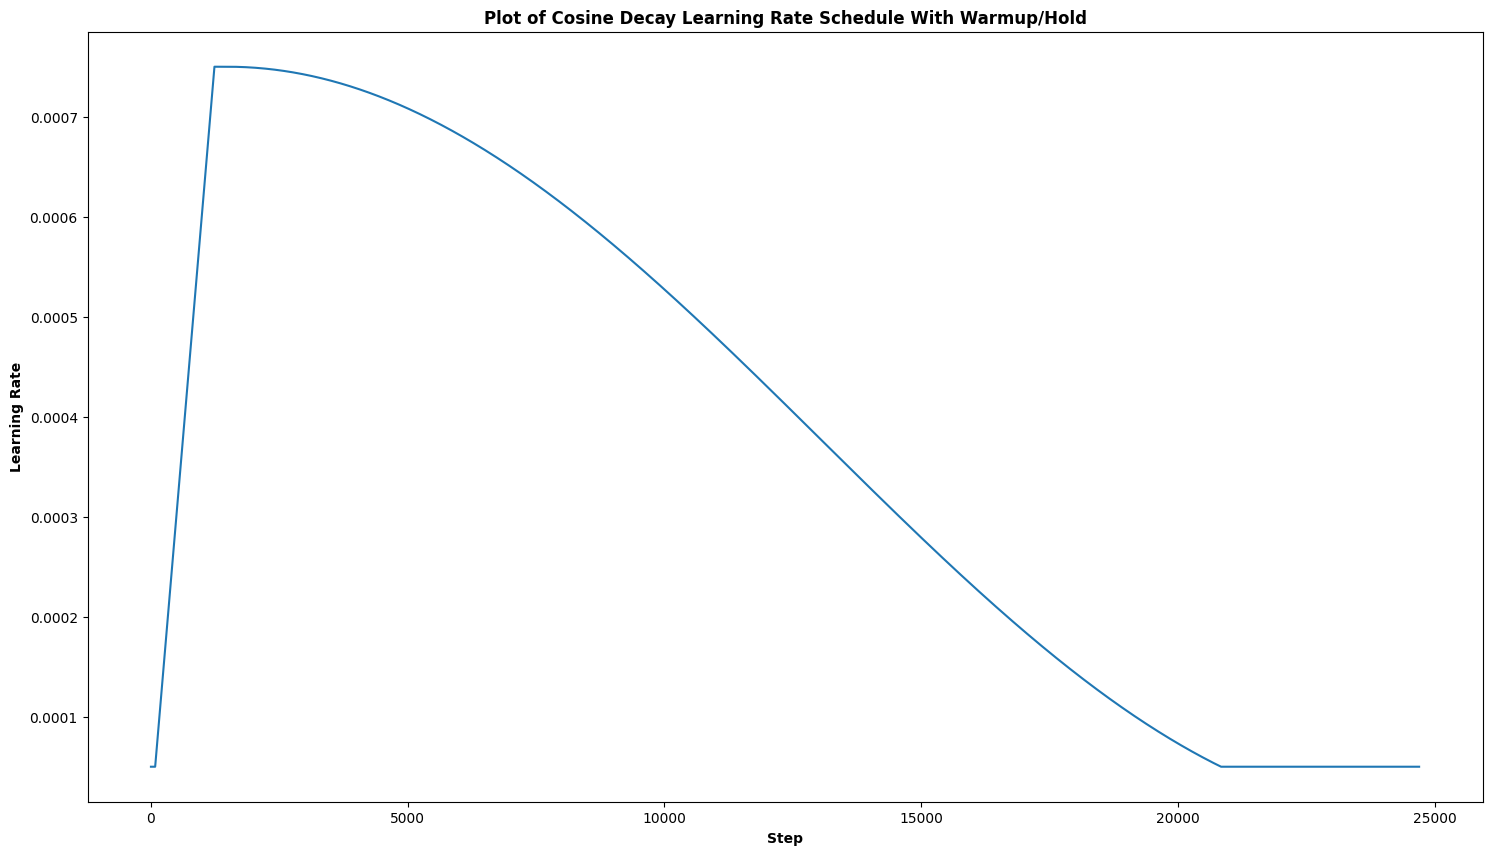

In [23]:
from spearecode.optimizers import AdamWeightDecay, WarmUpCosineDecay, plot_learning_rate

_n_ex_per_tfrec = 100
approx_total_steps = N_TOTAL_RECS*_n_ex_per_tfrec
approx_val_steps = N_VAL_RECS*_n_ex_per_tfrec
approx_train_steps = approx_total_steps-approx_val_steps

optimizer_config = dict(
    use_basic_adam=True,
    use_cdecay_lr=True,
    weight_decay_rate=0.1,
    clipnorm=True,
    gradient_clip_norm=1.0,
    beta_1=1.0,
    beta_2=0.95,
    exclude_from_weight_decay = ['layer_normalization', 'bias'],
)

lr_config = dict(
    init_lr=0.00075,
    min_lr=5e-05,
    decay_portion=1.0,
    warmup_portion=0.1,
    hold_portion=0.01,
    total_steps=approx_train_steps,
    alpha=0.0,
    decay_steps=approx_train_steps,
    warmup_steps=int(approx_train_steps*0.05),
    hold_steps=int(approx_train_steps*0.01),
)

# Instantiate our learning rate (or lr-schedule)
if optimizer_config["use_cdecay_lr"]:
    optimizer_config.pop("use_cdecay_lr")
    lr=WarmUpCosineDecay(**lr_config)
else:
    lr=lr_config["init_lr"]

# Instantiate our optimizer (AdamW or just vanilla Adam)
if not optimizer_config["use_basic_adam"]:
    optimizer_config.pop("use_basic_adam")
    optimizer = AdamWeightDecay(learning_rate=lr, **optimizer_config)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
plot_learning_rate(**lr_config)

In [24]:
from spearecode.callbacks import get_callbacks

class LearningRatePrinter(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate(self.model.optimizer.iterations)
        print(f"\nLearning rate at the end of epoch {epoch}: {lr.numpy()}")
        
CKPT_DIR = os.path.join(MODELS_DIR, "ckpts")
if not os.path.isdir(CKPT_DIR): 
    os.makedirs(CKPT_DIR, exist_ok=True)

cb_config = dict(
    ckpt_dir=CKPT_DIR,
    save_weights_only=True,
    use_early_stopping=True,
    es_patience=20,
    verbose=1,
)

cb_list = get_callbacks(cb_config)+[LearningRatePrinter(),]
cb_list

In [25]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fns = [
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # ENCODER MLM LOSS
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # DECODER AR  LOSS
]

metrics = [
    #TBD
]

In [26]:
# loss_weights=[0.5, 0.5]
# metrics = TBD
# validation_data=val_ds, callbacks=cb_list
cllm.compile(optimizer, loss=loss_fns, weighted_metrics=[], loss_weights=[0.334, 0.666])
history = cllm.fit(train_ds, validation_data=val_ds, epochs=train_config["n_epochs"], callbacks=cb_list)
# dec_bb.compile(optimizer, loss=loss_fn, weighted_metrics=[])
# history = dec_bb.fit(dec_train_ds, validation_data=dec_val_ds, epochs=train_config["n_epochs"], callbacks=cb_list)

Epoch 1/250
    192/Unknown - 30s 134ms/step - loss: 5.0555 - output_1_loss: 1.2080 - output_2_loss: 6.9851
Epoch 1: val_loss improved from inf to 4.32562, saving model to /home/paperspace/home/spearecode/models/ckpts

Learning rate at the end of epoch 0: 0.00011659919255180284
192/192 [==============================] - 36s 163ms/step - loss: 5.0555 - output_1_loss: 1.2080 - output_2_loss: 6.9851 - val_loss: 4.3256 - val_output_1_loss: 0.9569 - val_output_2_loss: 6.0150
Epoch 2/250
192/192 [==============================] - ETA: 0s - loss: 4.1116 - output_1_loss: 0.9485 - output_2_loss: 5.6979
Epoch 2: val_loss improved from 4.32562 to 3.93112, saving model to /home/paperspace/home/spearecode/models/ckpts

Learning rate at the end of epoch 1: 0.0002331983851036057
192/192 [==============================] - 30s 157ms/step - loss: 4.1116 - output_1_loss: 0.9485 - output_2_loss: 5.6979 - val_loss: 3.9311 - val_output_1_loss: 0.9561 - val_output_2_loss: 5.4231
Epoch 3/250
192/192 [========

KeyboardInterrupt: 

In [27]:
# x,y,s = next(iter(dec_val_ds))
# _y = dec_bb.predict(x)

x,y,s = next(iter(val_ds))
_y = cllm.predict(x)

4/4 [==============================] - 1s 17ms/step


In [28]:
# display(HTML(viz_tool()))
print("ALL")
_ = viz_tool(y[0][0].numpy().tolist()+x[1][0].numpy().tolist(), display_inline=True)

print("ENCODER")
_ = viz_tool(y[0][0].numpy().tolist(), display_inline=True)

print("DECODER")
_ = viz_tool(x[1][0].numpy().tolist(), display_inline=True)

ALL


ENCODER


DECODER


In [29]:
print("ENCODER INPUT")
_ = viz_tool(x[0][0].numpy().tolist(), display_inline=True)

print("ENCODER LABEL (FILLED IN)")
_ = viz_tool(y[0][0].numpy().tolist(), display_inline=True)

# tf.reduce_max(_y[0][0], axis=-1)
print("MODEL MLM PREDS")
_ = viz_tool(tf.argmax(_y[0][0], axis=-1).numpy().tolist(), display_inline=True)

ENCODER INPUT


ENCODER LABEL (FILLED IN)


MODEL MLM PREDS


In [30]:
print("DECODER INPUT")
_ = viz_tool(x[1][0].numpy().tolist(), display_inline=True)

print("DECODER OUTPUT (SHIFTED 1-RIGHT)")
_ = viz_tool(y[1][0].numpy().tolist(), display_inline=True)

# tf.reduce_max(_y[0][0], axis=-1)
print("MODEL AR PREDS")
_ = viz_tool(tf.argmax(_y[1][0], axis=-1).numpy().tolist(), display_inline=True)

DECODER INPUT


DECODER OUTPUT (SHIFTED 1-RIGHT)


MODEL AR PREDS
